# 2번 군집 데이터 불러오기

In [135]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, make_scorer
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])

# CLUSTER_1 == 1 데이터만 필터링
cluster1_df = df[df['CLUSTER_1'] == 2].copy()

# PORT_NAME 기준으로 라벨 인코딩
le = LabelEncoder()
cluster1_df['CLUSTER_2'] = le.fit_transform(cluster1_df['PORT_NAME'])

# 결과 확인
print("라벨링 완료된 CLUSTER_1 == 2 데이터")
# display(cluster1_df.head())
display(cluster1_df.sample(10))
print(f"CLUSTER_2 종류: {cluster1_df['CLUSTER_2'].unique().shape[0]}")

max_gap = pd.Timedelta(minutes=10)
hour = 14
time_based_data = []

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue # 비어있으면 continue로 패스
    start_time = group["TIMESTAMP"].min() # 출발 시점
    target_time = start_time + pd.Timedelta(hours=hour)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin() # 가장 작은 차이를 가진 인덱스 추출
    if time_diff[closest_idx] <= max_gap: # 10분보다 시간 차이 크면 무시
        closest_row = group.loc[closest_idx]
        time_based_data.append(closest_row) # 데이터 리스트에 저장
df_5h = pd.DataFrame(time_based_data).reset_index(drop=True)
df_5h

FileNotFoundError: [Errno 2] No such file or directory: './dataset/must_use_final.csv'

In [ ]:
df_5h.to_csv('./dataset/df_5h_extracted.csv', index=False)

# ✅ Oversampling + XGBoost + RandomForest


📦 [데이터 개수]
Train: 72개
Test : 19개
전체 : 91개
              precision    recall  f1-score   support

       CNNGB       0.40      1.00      0.57         2
       CNNJI       0.00      0.00      0.00         1
       CNSHA       0.85      0.73      0.79        15
       CNTAC       0.00      0.00      0.00         1

    accuracy                           0.68        19
   macro avg       0.31      0.43      0.34        19
weighted avg       0.71      0.68      0.68        19



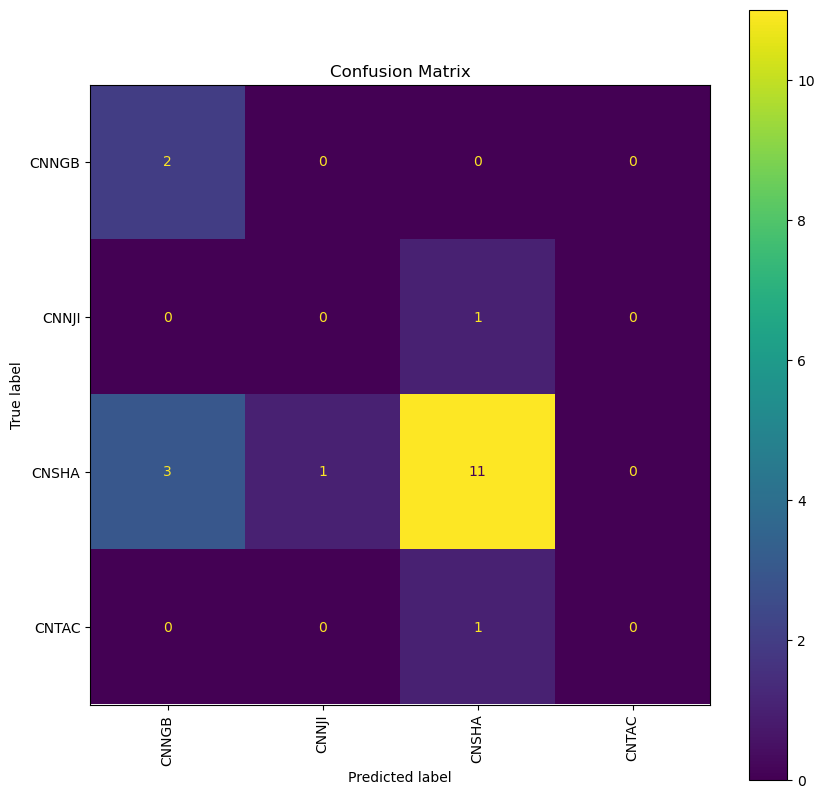

📊 [교차검증 결과]
Accuracy (Train): 0.9306
Accuracy (Test): 0.6842
CV Accuracy Mean: 0.7105 ± 0.1034
CV F1 Macro: 0.3449
CV Precision Macro: 0.3390
⚠️ 과적합 의심: 학습/테스트 정확도 차이 0.2463

📄 [Classification Report]
              precision    recall  f1-score   support

       CNNGB       0.40      1.00      0.57         2
       CNNJI       0.00      0.00      0.00         1
       CNSHA       0.85      0.73      0.79        15
       CNTAC       0.00      0.00      0.00         1

    accuracy                           0.68        19
   macro avg       0.31      0.43      0.34        19
weighted avg       0.71      0.68      0.68        19


📊 [교차검증 및 과적합 점검 결과]
학습 정확도              : 0.9306
테스트 정확도            : 0.6842
정확도 차이              : 0.2463 ⚠️ 과적합 의심
교차검증 평균 정확도     : 0.7105 ± 0.1034
교차검증 F1 매크로 평균  : 0.3449
교차검증 정밀도 평균     : 0.3390


In [4]:
# ===== 1. 라이브러리 =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.utils import resample

# ===== 3. 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
df_5h["label"] = y_encoded


# ===== 5. 학습/테스트 분리 =====
X_bal = df_5h[features]
y_bal = df_5h["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)


# 각 클래스에 대한 샘플 개수를 계산
class_counts = y_train.value_counts()

# 최대 클래스 수 계산
max_count = class_counts.max()

# 소수 클래스 정의: 클래스의 개수가 max_count * 1.5 이하인 클래스들을 소수 클래스로 정의
minority_classes = class_counts[class_counts < max_count * 1.5].index

# 샘플링 비율 설정
sampling_ratios = {
    0: 2.0,  # 클래스 0은 100% 오버샘플링
    1: 2.5,  # 클래스 1은 150% 오버샘플링
    2: 1.0,   # 클래스 2는 200% 오버샘플링
    3: 2.5
}

# 각 클래스에 대해 샘플링 비율을 적용하여 오버샘플링
resampled = []
for label in minority_classes:
    subset = X_train[y_train == label]
    # 비율에 맞춰 샘플을 늘리기
    n_samples = int(len(subset) * sampling_ratios.get(label, 1.0))  # 기본 1.0 비율로
    upsampled = resample(subset, replace=True, n_samples=n_samples, random_state=42)
    resampled.append(upsampled)

# 소수 클래스만 포함된 오버샘플링 데이터프레임 결합
X_train_resampled = pd.concat(resampled)
y_train_resampled = y_train[X_train_resampled.index]


# ===== 0. 데이터 수 출력 =====
print("\n📦 [데이터 개수]")
print(f"Train: {len(X_train)}개")
print(f"Test : {len(X_test)}개")
print(f"전체 : {len(X_train) + len(X_test)}개")

# ===== 6. 모델 정의 및 학습 (하이퍼파라미터 조정 포함) =====
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=50,
    max_depth=5,                 # 더 낮은 max_depth
    min_samples_leaf=5,          # 더 큰 min_samples_leaf
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=50,
    max_depth=3,                 # 더 낮은 max_depth
    learning_rate=0.05,
    reg_alpha=0.5,               # L1 규제 추가
    reg_lambda=1.0,              # L2 규제 추가
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

voting_clf.fit(X_train_resampled, y_train_resampled)

# ===== 7. 평가 =====
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

np.save("datasets/X_train_c2_14hours.npy", X_train_resampled)
np.save("datasets/X_test_c2_14hours.npy", X_test)
np.save("datasets/y_train_c2_14hours.npy", y_train_resampled)
np.save("datasets/y_test_c2_14hours.npy", y_test)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== 1. 교차검증 정확도 =====
acc_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy')
f1_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='f1_macro')
prec_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='precision_macro')

# ===== 2. 학습/테스트 정확도 =====
train_score = voting_clf.score(X_train, y_train)
test_score = voting_clf.score(X_test, y_test)
gap = train_score - test_score

# ===== 3. 예측 및 리포트 =====
y_pred = voting_clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)

# ===== 4. Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ===== 5. 결과 출력 =====
print("📊 [교차검증 결과]")
print(f"Accuracy (Train): {train_score:.4f}")
print(f"Accuracy (Test): {test_score:.4f}")
print(f"CV Accuracy Mean: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"CV F1 Macro: {f1_scores.mean():.4f}")
print(f"CV Precision Macro: {prec_scores.mean():.4f}")
if gap > 0.1:
    print(f"⚠️ 과적합 의심: 학습/테스트 정확도 차이 {gap:.4f}")
else:
    print("✅ 과적합 위험 없음")

print("\n📄 [Classification Report]")
print(report)

# ===== 5. 결과 출력 =====
print("\n📊 [교차검증 및 과적합 점검 결과]")
print(f"학습 정확도              : {train_score:.4f}")
print(f"테스트 정확도            : {test_score:.4f}")
print(f"정확도 차이              : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '과적합 위험 없음'}")
print(f"교차검증 평균 정확도     : {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"교차검증 F1 매크로 평균  : {f1_scores.mean():.4f}")
print(f"교차검증 정밀도 평균     : {prec_scores.mean():.4f}")

In [ ]:
# 오버샘플링된 레이블 → 항구명으로 다시 복원
df_balanced["PORT_NAME"] = le.inverse_transform(df_balanced["label"])

# 항구별 데이터 개수 출력
print("\n🛳️ [오버샘플링된 항구별 샘플 개수]")
print(df_balanced["PORT_NAME"].value_counts())

In [42]:
# 라벨 인코딩 객체 생성
le = LabelEncoder()

# 라벨 인코딩 수행
y_encoded = le.fit_transform(y)

# 라벨 인코딩된 값과 원래 클래스 이름 매핑 확인
label_mapping = pd.DataFrame({
    'Label': range(len(le.classes_)),
    'PORT_NAME': le.classes_
})

# 라벨 인코딩 결과 확인
print(label_mapping)


   Label PORT_NAME
0      0     CNNGB
1      1     CNNJI
2      2     CNSHA
3      3     CNTAC


In [ ]:
import numpy as np

# ===== [1] RandomForest 복잡도 분석 =====
rf_model = voting_clf.named_estimators_["rf"]
tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]

print("\n🌲 RandomForest 복잡도 정보")
print(f"- 트리 개수         : {len(tree_depths)}")
print(f"- 평균 깊이         : {np.mean(tree_depths):.2f}")
print(f"- 최대 깊이         : {np.max(tree_depths)}")
print(f"- 최소 깊이         : {np.min(tree_depths)}")

# ===== [2] XGBoost 복잡도 분석 =====
xgb_model = voting_clf.named_estimators_["xgb"]
booster = xgb_model.get_booster()
trees = booster.get_dump()

print("\n🔥 XGBoost 복잡도 정보")
print(f"- 트리 개수         : {len(trees)}")
print(f"- 설정된 max_depth  : {xgb.max_depth}")

# ===== [3] VotingClassifier 구성 확인 =====
print("\n🧠 VotingClassifier 구성 모델:")
for name, model in voting_clf.named_estimators_.items():
    print(f"- {name}: {type(model).__name__}")

# ===== [4] Accuracy Gap (= 복잡도 간접 지표) =====
gap = train_score - test_score
print(f"\n📉 Accuracy Gap (과적합 지표): {gap:.4f}")
if gap > 0.1:
    print("⚠️ 과적합 위험 → 복잡도 높음")
else:
    print("✅ 과적합 위험 없음 → 복잡도 적절")


In [54]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c2_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c2_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 4번 군집

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [111]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("./dataset/cluster1_4.csv")

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# 결과 저장 리스트
rows_5h = []

# 30번째 시점 추출 (10분 단위 × 30 = 5시간)
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    if len(group) >= 84:
        row_5h = group.iloc[83]  # 인덱스는 0부터 시작이므로 29번째가 30번째 행
        rows_5h.append(row_5h)

# 최종 데이터프레임
df_5h = pd.DataFrame(rows_5h).reset_index(drop=True)
print(df_5h.shape)
display(df_5h.head())
display(df_5h['PORT_NAME'].value_counts())

(32, 11)


,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2
0,CN,CNHUA,028690b9-6aba-3401-8d39-d602f2a30d82,2024-12-11 02:30:00,224.300000,224.000000,31.753972,126.405332,CNHUA,4,0
1,CN,CNHUA,091a653d-139a-33db-8f6d-2b5b389022d0,2024-09-02 16:30:00,220.200000,221.000000,32.448093,126.314127,CNHUA,4,0
2,HK,HKHKG,091a653d-139a-33db-8f6d-2b5b389022d0,2024-09-23 20:10:00,213.300000,216.000000,32.321093,126.596630,HKHKG,4,1
3,TW,TWKHH,0a0767cf-401a-3262-9c27-2f127d3ba8c1,2024-12-15 12:20:00,230.166667,229.666667,32.242647,126.078571,TWKHH,4,3
4,CN,CNHUA,0d13aad6-3c22-37e0-9106-76e8bb48e51e,2024-12-02 17:20:00,209.750000,210.000000,32.250801,126.769344,CNHUA,4,0


PORT_NAME
HKHKG    10
TWKEL    10
CNHUA     7
TWKHH     5
Name: count, dtype: int64

In [113]:
# 데이터 준비
X = df[['LAT', 'LON', 'COG', 'HEADING']].values
y = df['CLUSTER_2'].values

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_resampled, y_train_resampled = resample(X_train, y_train, 
                                                replace=True, n_samples=len(X_train), random_state=42)

np.save("datasets/X_train_c4_14hours.npy", X_train_resampled)
np.save("datasets/X_test_c4_14hours.npy", X_test)
np.save("datasets/y_train_c4_14hours.npy", y_train_resampled)
np.save("datasets/y_test_c4_14hours.npy", y_test)

## 보류

최적 하이퍼파라미터: {'knn__n_neighbors': 5, 'rf__max_depth': 10, 'xgb__max_depth': 5}
최고 성능: 0.806350864474972
모델 성능 평가:
              precision    recall  f1-score   support

           0       0.72      0.60      0.65       930
           1       0.61      0.80      0.69       906
           2       0.80      0.80      0.80       552
           3       0.91      0.70      0.80       550

    accuracy                           0.72      2938
   macro avg       0.76      0.73      0.74      2938
weighted avg       0.74      0.72      0.72      2938

Training Accuracy: 0.8789
Test Accuracy: 0.7192
Overfitting Difference (훈련 - 테스트 정확도 차이): 0.1597
모델이 과적합되었습니다.

교차검증 평균 정확도: 0.5756
교차검증 표준편차: 0.0522


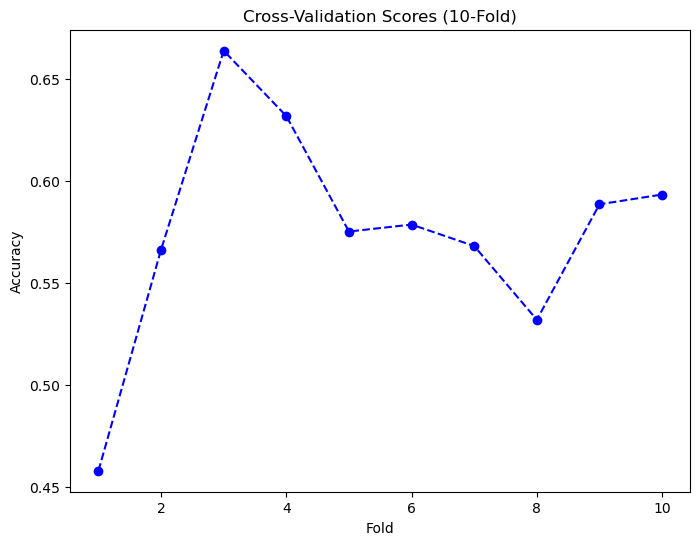

In [117]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 하이퍼파라미터 튜닝 범위 정의

# RandomForestClassifier 하이퍼파라미터 (모델 복잡도 더욱 감소 및 정규화)
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10],  # max_depth 제한
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'learning_rate': [0.05, 0.1]  # 학습률 추가
}

# XGBClassifier 하이퍼파라미터 (정규화 및 모델 복잡도 감소)
xgb_params = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],  # 학습률 추가
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9],  # 데이터를 일부만 사용하여 과적합 방지
    'colsample_bytree': [0.8, 0.9],  # 열 샘플링 비율 설정
    'reg_alpha': [1, 10],  # L1 정규화 (과적합 방지)
    'reg_lambda': [1, 10],   # L2 정규화 (과적합 방지)
    'early_stopping_rounds': [10]  # early stopping 추가
}

# KNeighborsClassifier 하이퍼파라미터 (모델 복잡도 감소)
knn_params = {
    'n_neighbors': [5, 10],
    'weights': ['uniform'],
    'metric': ['euclidean']
}

# 개별 모델 정의
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
knn = KNeighborsClassifier()

# VotingClassifier (Hard Voting)
voting_clf = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('knn', knn)], voting='hard')  # 하드 보팅으로 변경

# GridSearchCV 설정 (VotingClassifier에 대한 파라미터 튜닝)
param_grid = {
    'rf__max_depth': [5, 10],
    'xgb__max_depth': [3, 5],
    'knn__n_neighbors': [5, 10]
}

# GridSearchCV 실행 (교차검증을 통해 과적합 방지)
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)  # cv를 10으로 늘림

# 오버샘플링 적용 후 학습 및 평가
grid_search.fit(X_train_resampled, y_train_resampled)

# 최적 하이퍼파라미터 및 성능 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 성능:", grid_search.best_score_)

# 테스트 데이터로 예측
y_pred = grid_search.best_estimator_.predict(X_test)

# 성능 평가
print("모델 성능 평가:")
print(classification_report(y_test, y_pred))

# 과적합 확인: 훈련 세트와 테스트 세트의 정확도를 비교
train_accuracy = grid_search.best_estimator_.score(X_train_resampled, y_train_resampled)
test_accuracy = grid_search.best_estimator_.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

overfitting_difference = train_accuracy - test_accuracy
print(f"Overfitting Difference (훈련 - 테스트 정확도 차이): {overfitting_difference:.4f}")

if overfitting_difference > 0.1:
    print("모델이 과적합되었습니다.")
else:
    print("모델이 과적합되지 않았습니다.")

# 교차검증 (Cross-Validation): K-fold 교차검증을 사용하여 모델의 일반화 성능 평가
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=10, scoring='accuracy')  # cv=10

# 교차검증 평균 정확도와 표준편차 출력
print(f"\n교차검증 평균 정확도: {cv_scores.mean():.4f}")
print(f"교차검증 표준편차: {cv_scores.std():.4f}")

# 교차검증 결과 시각화
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='--', color='b', label="Cross-Validation Scores")
plt.title("Cross-Validation Scores (10-Fold)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()


In [118]:
from sklearn.metrics import accuracy_score
import pandas as pd

# 예측값 생성
y_pred = grid_search.best_estimator_.predict(X_test)

# 예측 결과와 실제 값을 데이터프레임으로 생성
results_df = pd.DataFrame({
    'True': y_test,
    'Predicted': y_pred
})

# 항구별 정확도 계산 (CLUSTER_2 또는 PORT_NAME을 기준으로 그룹화)
# 결과가 여러 항구를 다루므로 항구별로 정확도를 계산
grouped_accuracy = results_df.groupby('True').apply(lambda group: accuracy_score(group['True'], group['Predicted']))

# 항구별 정확도 출력
print("\n항구별 정확도:")
print(grouped_accuracy)


항구별 정확도:
True
0    0.602151
1    0.796909
2    0.804348
3    0.703636
dtype: float64


In [119]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c4_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c4_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 7번 군집

In [144]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("./dataset/cluster1_7.csv")

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# 결과 저장 리스트
rows_5h = []

# 30번째 시점 추출 (10분 단위 × 30 = 5시간)
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    if len(group) >= 84:
        row_5h = group.iloc[83]  # 인덱스는 0부터 시작이므로 29번째가 30번째 행
        rows_5h.append(row_5h)

# 최종 데이터프레임
df_5h = pd.DataFrame(rows_5h).reset_index(drop=True)
print(df_5h.shape)
display(df_5h.head())
display(df_5h['PORT_NAME'].value_counts())

(25, 11)


,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2
0,RU,RUVVO,0359a9fc-db7a-3187-9550-f9a3b3c90f37,2024-08-20 23:20:00,18.976389,16.958333,38.069151,130.816610,RUVVO,7,1
1,RU,RUNJK,060db0be-c97f-3f11-8304-c637fe4fa4d5,2024-10-17 04:20:00,22.572000,22.320000,37.824331,130.776241,RUNJK,7,0
2,RU,RUVVO,06912aab-4dd2-319e-b14f-6766b17d0d72,2024-09-15 13:50:00,56.323226,50.832258,34.960723,129.314145,RUVVO,7,1
3,RU,RUVVO,091a653d-139a-33db-8f6d-2b5b389022d0,2024-10-31 23:20:00,43.350000,45.000000,37.678017,132.284348,RUVVO,7,1
4,RU,RUVVO,1efac1d5-4f2a-3fef-917e-a9f480f0853b,2024-07-17 22:30:00,134.439310,131.986207,35.031609,129.104421,RUVVO,7,1


PORT_NAME
RUVVO    21
RUNJK     4
Name: count, dtype: int64

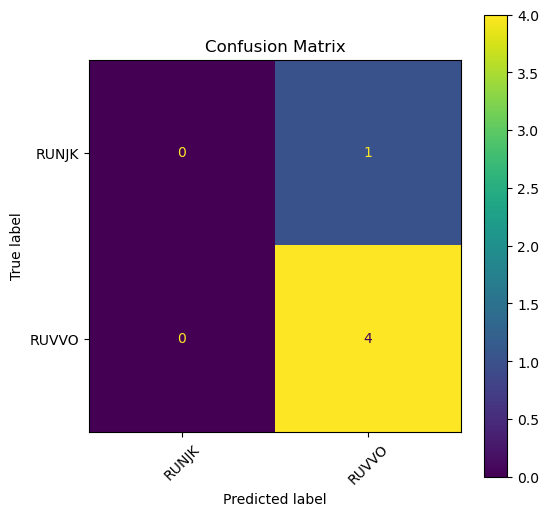


📦 [데이터 개수]
Train: 20개
Test : 5개
Resampled Train: 27개

📊 [교차검증 및 과적합 점검 결과]
학습 정확도              : 0.8298
테스트 정확도            : 0.6000
정확도 차이              : 0.2298 ⚠️ 과적합 의심
교차검증 평균 정확도     : 0.6667 ± 0.2201
교차검증 F1 매크로 평균  : 0.6179
교차검증 정밀도 평균     : 0.6100

📄 [Classification Report]
              precision    recall  f1-score   support

       RUNJK       0.00      0.00      0.00         1
       RUVVO       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



In [174]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.utils import resample, compute_sample_weight
import matplotlib.pyplot as plt
from collections import Counter

# ===== 데이터 준비 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
df_5h["label"] = y_encoded

X = df_5h[features]
y = df_5h["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== 오버샘플링 =====
class_counts = Counter(y_train)
mean_count = int(np.mean(list(class_counts.values())))

# 소수 클래스 기준으로 오버샘플링 비율 계산
minority_classes = [label for label, count in class_counts.items() if count < mean_count]
sampling_ratios = {label: mean_count / count for label, count in class_counts.items() if count < mean_count}

resampled_X = []
resampled_y = []

for label in class_counts:
    subset_X = X_train[y_train == label]
    subset_y = y_train[y_train == label]
    if label in sampling_ratios:
        n_samples = int(len(subset_X) * sampling_ratios[label])
        up_X, up_y = resample(subset_X, subset_y, replace=True, n_samples=n_samples, random_state=42)
    else:
        up_X, up_y = subset_X, subset_y

    resampled_X.append(up_X)
    resampled_y.append(up_y)

X_train_resampled = pd.concat(resampled_X)
y_train_resampled = pd.concat(resampled_y)

# ===== sample_weight 계산 (XGBoost에만 사용) =====
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_resampled)

# ===== 모델 정의 =====
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=50,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.05,
    reg_alpha=0.5,
    reg_lambda=1.0,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

lr = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)

# ===== Soft VotingClassifier =====
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lr', lr)],
    voting='soft',
    weights=[1, 2, 1]
)

# ===== 학습 =====
# voting_clf.fit(
#     X_train_resampled,
#     y_train_resampled,
#     xgb__sample_weight=sample_weights
# )

# # ===== 예측 및 평가 =====
# y_pred = voting_clf.predict(X_test)

rf.fit(X_train_resampled, y_train_resampled)
lr.fit(X_train_resampled, y_train_resampled)
xgb.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)

rf_probs = rf.predict_proba(X_test)
lr_probs = lr.predict_proba(X_test)
xgb_probs = xgb.predict_proba(X_test)

# Soft voting 기반 학습 정확도 계산
rf_probs_train = rf.predict_proba(X_train_resampled)
lr_probs_train = lr.predict_proba(X_train_resampled)
xgb_probs_train = xgb.predict_proba(X_train_resampled)

final_probs_train = (1 * rf_probs_train + 1 * lr_probs_train + 2 * xgb_probs_train) / 4
train_pred = np.argmax(final_probs_train, axis=1)

train_score = accuracy_score(y_train_resampled, train_pred)
test_score = accuracy_score(y_test, y_pred)
gap = train_score - test_score



cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# 교차검증
# acc_scores = cross_val_score(voting_clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
# f1_scores = cross_val_score(voting_clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro')
# prec_scores = cross_val_score(voting_clf, X_train_resampled, y_train_resampled, cv=5, scoring='precision_macro')

# train_score = voting_clf.score(X_train_resampled, y_train_resampled)
# test_score = voting_clf.score(X_test, y_test)
# gap = train_score - test_score

# ===== 결과 출력 =====
report = classification_report(y_test, y_pred, target_names=le.classes_)

print("\n📦 [데이터 개수]")
print(f"Train: {len(X_train)}개")
print(f"Test : {len(X_test)}개")
print(f"Resampled Train: {len(X_train_resampled)}개")

print("\n📊 [교차검증 및 과적합 점검 결과]")
print(f"학습 정확도              : {train_score:.4f}")
print(f"테스트 정확도            : {test_score:.4f}")
print(f"정확도 차이              : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '✅ 과적합 위험 없음'}")
print(f"교차검증 평균 정확도     : {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"교차검증 F1 매크로 평균  : {f1_scores.mean():.4f}")
print(f"교차검증 정밀도 평균     : {prec_scores.mean():.4f}")

print("\n📄 [Classification Report]")
print(report)

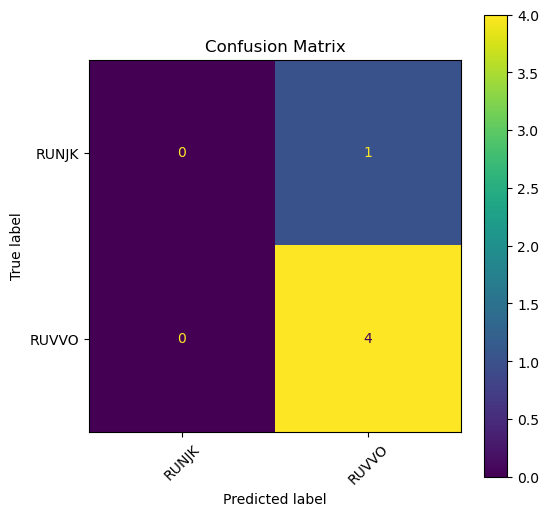


📦 [데이터 개수]
Train: 20개
Test : 5개
Resampled Train: 27개

📊 [성능 평가]
학습 정확도              : 0.8889
테스트 정확도            : 0.8000
정확도 차이              : 0.0889 ✅ 과적합 위험 없음

📄 [Classification Report]
              precision    recall  f1-score   support

       RUNJK       0.00      0.00      0.00         1
       RUVVO       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



In [177]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)
from xgboost import XGBClassifier
from sklearn.utils import resample, compute_sample_weight
from collections import Counter
import matplotlib.pyplot as plt

# ===== 예시 데이터프레임 df_5h 정의 (사용자 코드에서는 이미 정의되어 있어야 함) =====
# 이 줄은 실제 사용자 코드에서는 생략하세요.
# df_5h = pd.read_csv('your_data.csv')

# ===== 데이터 준비 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
df_5h["label"] = y_encoded

X = df_5h[features]
y = df_5h["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== 오버샘플링 =====
class_counts = Counter(y_train)
mean_count = int(np.mean(list(class_counts.values())))

minority_classes = [label for label, count in class_counts.items() if count < mean_count]
sampling_ratios = {label: mean_count / count for label, count in class_counts.items() if count < mean_count}

resampled_X = []
resampled_y = []

for label in class_counts:
    subset_X = X_train[y_train == label]
    subset_y = y_train[y_train == label]
    if label in sampling_ratios:
        n_samples = int(len(subset_X) * sampling_ratios[label])
        up_X, up_y = resample(subset_X, subset_y, replace=True, n_samples=n_samples, random_state=42)
    else:
        up_X, up_y = subset_X, subset_y

    resampled_X.append(up_X)
    resampled_y.append(up_y)

X_train_resampled = pd.concat(resampled_X)
y_train_resampled = pd.concat(resampled_y)

# ===== sample_weight (XGB 전용) =====
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_resampled)

# ===== 모델 정의 =====
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=50,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.05,
    reg_alpha=0.5,
    reg_lambda=1.0,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

lr = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)

# ===== 개별 학습 =====
rf.fit(X_train_resampled, y_train_resampled)
lr.fit(X_train_resampled, y_train_resampled)
xgb.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)

# ===== 테스트 예측 (soft voting) =====
rf_probs = rf.predict_proba(X_test)
lr_probs = lr.predict_proba(X_test)
xgb_probs = xgb.predict_proba(X_test)

final_probs = (1 * rf_probs + 1 * lr_probs + 2 * xgb_probs) / 4
y_pred = np.argmax(final_probs, axis=1)

# ===== 훈련 정확도 계산 =====
rf_probs_train = rf.predict_proba(X_train_resampled)
lr_probs_train = lr.predict_proba(X_train_resampled)
xgb_probs_train = xgb.predict_proba(X_train_resampled)

final_probs_train = (1 * rf_probs_train + 1 * lr_probs_train + 2 * xgb_probs_train) / 4
train_pred = np.argmax(final_probs_train, axis=1)

train_score = accuracy_score(y_train_resampled, train_pred)
test_score = accuracy_score(y_test, y_pred)
gap = train_score - test_score

# ===== 시각화 =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ===== 출력 =====
report = classification_report(y_test, y_pred, target_names=le.classes_)

print("\n📦 [데이터 개수]")
print(f"Train: {len(X_train)}개")
print(f"Test : {len(X_test)}개")
print(f"Resampled Train: {len(X_train_resampled)}개")

print("\n📊 [성능 평가]")
print(f"학습 정확도              : {train_score:.4f}")
print(f"테스트 정확도            : {test_score:.4f}")
print(f"정확도 차이              : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '✅ 과적합 위험 없음'}")

print("\n📄 [Classification Report]")
print(report)


In [152]:
print(f"✅ 오버샘플링 후 훈련 샘플 수: {len(X_train_resampled)}개")
print(f"✅ 오버샘플링 후 라벨 수    : {len(y_train_resampled)}개")

✅ 오버샘플링 후 훈련 샘플 수: 32개
✅ 오버샘플링 후 라벨 수    : 32개
